In [4]:
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
import numpy as np
import sklearn

In [5]:
from confidenceinterval import classification_report_with_ci
from confidenceinterval.bootstrap import bootstrap_ci


# Evaluate Multi-Class


## Load individual file with predictions

Skip the below if you have already loaded multiple files!

In [6]:
prompt_ids_to_eval = ["P2_HIERARCHY"] #["P1_HIERARCHY", "P2_HIERARCHY"] # ["P6", "P7", "P11_3", "P11_4"]
model = "gpt-4-turbo-preview" #"gpt-3.5-turbo" "gpt-4-turbo-preview"
data_type = "enriched_kw" # change when evaluating enriched without kw/ not enriched to be able to load and save the correct names

In [7]:
# Create the list of prediction columns based on the prompt IDs
prediction_columns = [f'gpt_predictions_{prompt_id}' for prompt_id in prompt_ids_to_eval]
# Specify the basic columns to include in the DataFrame
basic_columns = ['pmid', 'accepted_label', 'multi_label', 'binary_label']
# Combine basic columns with the dynamically generated prediction columns
columns_to_read = basic_columns + prediction_columns

df = pd.read_csv(f"predictions/{model}_{data_type}_test_outputs_P3_{'_'.join(prompt_ids_to_eval)}_hierarchical.csv")[columns_to_read]

In [8]:
columns_to_read

['pmid',
 'accepted_label',
 'multi_label',
 'binary_label',
 'gpt_predictions_P2_HIERARCHY']

In [9]:
df.shape

(534, 5)

In [10]:
df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P2_HIERARCHY
0,32147509,Non-systematic-review,1,0,Animal-other
1,16312938,Non-systematic-review,1,0,Animal-non-drug-intervention
2,23811310,Non-systematic-review,1,0,Animal-other
3,33846423,Remaining,0,0,Animal-other
4,11909745,Remaining,0,0,Animal-other


## Map predictions to numerical

In [11]:
label_to_numerical = {
    'Remaining': 0,
    'Non-systematic-review': 1,
    'Human-non-RCT-non-drug-intervention': 2,
    'Human-non-RCT-drug-intervention': 3,
    'Human-case-report': 4,
    'Animal-other': 5,
    'Animal-drug-intervention': 6,
    'Human-systematic-review': 7,
    'In-vitro-study': 8,
    'Human-RCT-non-drug-intervention': 9,
    'Animal-non-drug-intervention': 10,
    'Human-RCT-drug-intervention': 11,
    'Clinical-study-protocol': 12,
    'Human-RCT-non-intervention': 13
}

In [12]:
numerical_to_label = {v: f"{k}" for k, v in label_to_numerical.items()}
numerical_to_label

{0: 'Remaining',
 1: 'Non-systematic-review',
 2: 'Human-non-RCT-non-drug-intervention',
 3: 'Human-non-RCT-drug-intervention',
 4: 'Human-case-report',
 5: 'Animal-other',
 6: 'Animal-drug-intervention',
 7: 'Human-systematic-review',
 8: 'In-vitro-study',
 9: 'Human-RCT-non-drug-intervention',
 10: 'Animal-non-drug-intervention',
 11: 'Human-RCT-drug-intervention',
 12: 'Clinical-study-protocol',
 13: 'Human-RCT-non-intervention'}

In [13]:
import difflib
def map_label_fuzzy(label, label_dict):
    #label = label.lower().replace('-', '').replace('_', ' ').strip()
    best_match = difflib.get_close_matches(label, label_dict.keys(), n=1, cutoff=0.6)
    if best_match:
        #print(f'{label} matched to {best_match[0]}')
        return label_dict[best_match[0]]
    return -1

In [14]:
map_label_fuzzy("RCT-drug-intervention", label_to_numerical)

11

In [15]:
def map_label_to_numerical(label, label_dict):
    # Check if label is a dictionary
    if isinstance(label, dict):
        print(label)
        # Extract the label with the highest score/probability
        highest_label = max(normalized_label, key=label.get)
        return label_dict.get(highest_label, -1)
    else:
         # Normalize label
        normalized_label = label.replace(',', '').strip().replace(' ', '-')#.strip()
        # Directly map string labels to numerical IDs
        numerical_label = label_dict.get(label, -1)
        # Fuzzy match if no direct mapping possible
        if numerical_label == -1:
            numerical_label = map_label_fuzzy(normalized_label, label_dict)
        # If fuzzy match did not work, check if the label string contains the key 'label' and use it to split the string; keep everything to the right as the potential label
        if numerical_label == -1:
            if 'label' in label:
                label_part = label.split('label')[1]
                numerical_label = map_label_fuzzy(label_part, label_dict)
        return numerical_label
        
# Convert accepted labels to numerical
df['accepted_label_numerical'] = df['accepted_label'].apply(lambda x: map_label_to_numerical(x, label_to_numerical))


for col in prediction_columns:
    df[f'{col}_numerical'] = df[col].apply(lambda x: map_label_to_numerical(x, label_to_numerical))

df.head()

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P2_HIERARCHY,accepted_label_numerical,gpt_predictions_P2_HIERARCHY_numerical
0,32147509,Non-systematic-review,1,0,Animal-other,1,5
1,16312938,Non-systematic-review,1,0,Animal-non-drug-intervention,1,10
2,23811310,Non-systematic-review,1,0,Animal-other,1,5
3,33846423,Remaining,0,0,Animal-other,0,5
4,11909745,Remaining,0,0,Animal-other,0,5


In [16]:
def is_list_of_lists(lst):
    return all(isinstance(sublist, list) for sublist in lst)

if is_list_of_lists(prompt_ids_to_eval):
    # Flatten the list of lists
    prompt_ids_to_eval_flat = [item for sublist in prompt_ids_to_eval for item in sublist]
    # Create a string suffix for the CSV file name
    csv_file_suffix = '_'.join(prompt_ids_to_eval_flat)
else:
    csv_file_suffix = '_'.join(prompt_ids_to_eval)

In [17]:
csv_file_suffix = 'P3_P2_HIERARCHY' #redefine

In [18]:
df.to_csv(f"predictions/{model}_{data_type}_test_outputs_{'_'.join(csv_file_suffix)}_structured.csv")

#### Important: some labels from GPT could not be mapped to a target label

In [19]:
rows_with_minus_one = df[(df == -1).any(axis=1)]
rows_with_minus_one

,pmid,accepted_label,multi_label,binary_label,gpt_predictions_P2_HIERARCHY,accepted_label_numerical,gpt_predictions_P2_HIERARCHY_numerical


## Evaluate prompts

In [20]:
def evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, csv_file_suffix=None, digits=3):
    report_dfs = []
    summary_stats = []

    for prompt_id in prompt_ids_to_eval:
        print("Evaluating ", prompt_id)
        prediction_col = f'gpt_predictions_{prompt_id}'

        # Extract arrays for evaluation
        y_true = df[target_label_col].values
        y_pred = df[f'{prediction_col}_numerical'].values
        cm = confusion_matrix(y_true, y_pred, labels=range(len(label_to_numerical)))
        
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        accuracy_balanced = balanced_accuracy_score(y_true, y_pred)
        report = classification_report_with_ci(y_true, y_pred, numerical_to_label_map=numerical_to_label, round_ndigits = digits)
        
        # Create DataFrame from report
        report_df = pd.DataFrame(report)
        report_df['Prompt ID'] = prompt_id
        report_dfs.append(report_df)
        
        # Extract summary statistics
        report_df.set_index('class', inplace=True)
        summary = report_df.loc['weighted avg', ['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI']].to_dict()
        summary['Prompt ID'] = prompt_id
        summary_stats.append(summary)

        # Plotting confusion matrix
        plt.figure(figsize=(10, 6))
        ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(label_to_numerical)), yticklabels=range(len(label_to_numerical)))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=13)
        plt.title(f'Confusion Matrix for Model {model} and Prompt {prompt_id}', fontsize=14)
        plt.xlabel('Predicted Labels', fontsize=13)
        plt.ylabel('True Labels', fontsize=13)

        # Add an inset with label mapping
        textstr = '\n'.join([f'{v}: {k}' for k, v in label_to_numerical.items()])
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(1.16, 1.0, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        plt.tight_layout()
        plt.savefig(f'plots/confusion_matrix_{model}_{data_type}_P3_{prompt_id}_{eval_type}_with_ci.pdf')  # Save to PDF

    # Combine all report DataFrames
    all_reports_df = pd.concat(report_dfs)

    # Create a summary table for average precision, recall, and F1-score
    summary_df = pd.DataFrame(summary_stats)

    if not csv_file_suffix:
        csv_file_suffix = '_'.join(prompt_ids_to_eval) + "_" + eval_type
    
    # Save results to CSV files
    all_reports_df.to_csv(f"evaluations/{model}_{data_type}_test_per_class_{csv_file_suffix}_{eval_type}_with_ci.csv")
    summary_df.to_csv(f"evaluations/{model}_{data_type}_test_summary_{csv_file_suffix}_{eval_type}_with_ci.csv")
    
    print("Results saved to evaluations/ and plots/ folders.")

    return all_reports_df, summary_df


In [21]:
csv_file_suffix

'P3_P2_HIERARCHY'

In [22]:
prompt_ids_to_eval

['P2_HIERARCHY']

Evaluating  P2_HIERARCHY


/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:190: RuntimeWarning: invalid value encountered in divide
  q_ = count_a / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:282: RuntimeWarning: divide by zero encountered in divide
  denom = 1 + crit2 / nobs_a
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:283: RuntimeWarning: divide by zero encountered in scalar divide
  center = (q_ + crit2 / (2 * nobs_a)) / denom
/Users/shirin 1/prodigy/lib/python3.10/site-packages/statsmodels/stats/proportion.py:285: RuntimeWarning: divide by zero encountered in scalar divide
  q_ * (1.0 - q_) / nobs_a + crit2 / (4.0 * nobs_a**2)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confidenceinterval/takahashi_methods.py:83: RuntimeWarning: invalid value encountered in divide
  P_i = np.diag(p / total_detected_as_each_category)
/Users/shirin 1/prodigy/lib/python3.10/site-packages/confi

Results saved to evaluations/ and plots/ folders.


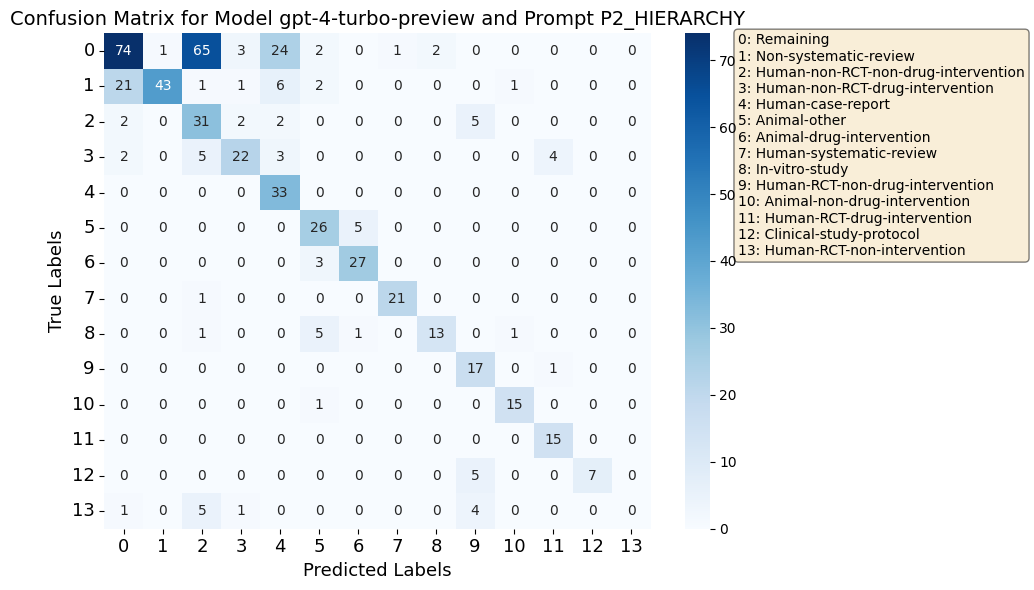

In [23]:
target_label_col = 'accepted_label_numerical'
eval_type = 'hierarchical'
all_reports_df, summary_df = evaluate_predictions_with_ci(df, target_label_col, prompt_ids_to_eval, model, eval_type, label_to_numerical, numerical_to_label, csv_file_suffix)


In [24]:
summary_df

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.741,"(0.699, 0.772)",0.644,"(0.603, 0.684)",0.645,"(0.603, 0.686)",0.644,"(0.603, 0.684)",P2_HIERARCHY


In [25]:
all_reports_df

,precision,recall,f1-score,accuracy,precision CI,recall CI,f1-score CI,accuracy CI,support,Prompt ID
class,,,,,,,,,,
Remaining,0.740,0.430,0.544,0.768,"(0.646, 0.816)","(0.359, 0.505)","(0.473, 0.615)","(0.73, 0.802)",172,P2_HIERARCHY
Non-systematic-review,0.977,0.573,0.723,0.938,"(0.882, 0.996)","(0.461, 0.679)","(0.631, 0.814)","(0.914, 0.956)",75,P2_HIERARCHY
Human-non-RCT-non-drug-intervention,0.284,0.738,0.411,0.833,"(0.208, 0.375)","(0.589, 0.847)","(0.311, 0.51)","(0.799, 0.863)",42,P2_HIERARCHY
Human-non-RCT-drug-intervention,0.759,0.611,0.677,0.961,"(0.579, 0.878)","(0.449, 0.752)","(0.545, 0.808)","(0.941, 0.974)",36,P2_HIERARCHY
Human-case-report,0.485,1.000,0.653,0.934,"(0.371, 0.602)","(0.896, 1.0)","(0.546, 0.761)","(0.91, 0.952)",33,P2_HIERARCHY
Animal-other,0.667,0.839,0.743,0.966,"(0.51, 0.794)","(0.674, 0.929)","(0.627, 0.859)","(0.947, 0.979)",31,P2_HIERARCHY
Animal-drug-intervention,0.818,0.900,0.857,0.983,"(0.656, 0.914)","(0.744, 0.965)","(0.762, 0.952)","(0.968, 0.991)",30,P2_HIERARCHY
Human-systematic-review,0.955,0.955,0.955,0.996,"(0.782, 0.992)","(0.782, 0.992)","(0.89, 1.019)","(0.986, 0.999)",22,P2_HIERARCHY
In-vitro-study,0.867,0.619,0.722,0.981,"(0.621, 0.963)","(0.409, 0.792)","(0.556, 0.888)","(0.966, 0.99)",21,P2_HIERARCHY


## Format Results and Generate LateX

In [126]:
# Case of combining separately evaluated prompt files

model = "gpt-3.5-turbo"

prompt_ids_to_eval = ["P1_HIERARCHY", "P2_HIERARCHY"]
summary_gpt3_raw_1 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_P1_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P1_HIERARCHY", "P2_HIERARCHY"]
summary_gpt3_raw_2 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_P2_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

prompt_ids_to_eval = ["P1_HIERARCHY", "P2_HIERARCHY"]
summary_gpt3_raw_3 = pd.read_csv(f"evaluations/{model}_{data_type}_test_summary_P3_{'_'.join(prompt_ids_to_eval)}_{eval_type}_with_ci.csv", index_col=0)

summary_gpt3_raw = pd.concat([summary_gpt3_raw_1,summary_gpt3_raw_2, summary_gpt3_raw_3]) 
summary_gpt3_raw

,precision,precision CI,recall,recall CI,f1-score,f1-score CI,accuracy,accuracy CI,Prompt ID
0,0.448,"(0.358, 0.529)",0.311,"(0.273, 0.352)",0.258,"(0.218, 0.301)",0.311,"(0.272, 0.352)",P1_HIERARCHY
1,0.580,"(0.524, 0.621)",0.507,"(0.466, 0.551)",0.502,"(0.459, 0.546)",0.507,"(0.466, 0.551)",P2_HIERARCHY
0,0.452,"(0.36, 0.534)",0.313,"(0.273, 0.352)",0.265,"(0.224, 0.308)",0.313,"(0.273, 0.354)",P1_HIERARCHY
1,0.587,"(0.529, 0.626)",0.504,"(0.463, 0.545)",0.499,"(0.456, 0.544)",0.504,"(0.463, 0.547)",P2_HIERARCHY
0,0.515,"(0.418, 0.586)",0.346,"(0.307, 0.388)",0.295,"(0.253, 0.338)",0.346,"(0.307, 0.39)",P1_HIERARCHY
1,0.617,"(0.561, 0.655)",0.551,"(0.507, 0.592)",0.540,"(0.496, 0.585)",0.551,"(0.507, 0.594)",P2_HIERARCHY


In [127]:
map_prompt_to_concept = {
    'P1_HIERARCHY': 'zero-shot',
    'P2_HIERARCHY': 'CC'
}

In [128]:
# Custom sorting function
def custom_sort(prompt):
    import re
    # Extract numbers from the prompt
    numbers = re.findall(r'\d+', prompt)
    if numbers:
        # Primary sort by the first number, secondary sort by the full string
        return (int(numbers[0]), prompt)
    return (float('inf'), prompt)  # Handles cases without numbers
    
def format_summary_for_latex_report(summary_df, map_prompt_to_concept):
    summary_df = summary_df.copy()
    
    # Concatenating each metric with its CI
    summary_df['Precision (CI)'] = summary_df['precision'].astype(str) + ' ' + summary_df['precision CI'].astype(str)
    summary_df['Recall (CI)'] = summary_df['recall'].astype(str) + ' ' + summary_df['recall CI'].astype(str)
    summary_df['F1-Score (CI)'] = summary_df['f1-score'].astype(str) + ' ' + summary_df['f1-score CI'].astype(str)
    summary_df['Accuracy (CI)'] = summary_df['accuracy'].astype(str) + ' ' + summary_df['accuracy CI'].astype(str)
    
    # Dropping old columns
    summary_df.drop(columns=['precision', 'precision CI', 'recall', 'recall CI', 'f1-score', 'f1-score CI', 'accuracy', 'accuracy CI'], inplace=True)
    
    # Rename 'Prompt ID' to 'Prompt'
    summary_df.rename(columns={'Prompt ID': 'Prompt'}, inplace=True)
    
    # Apply the mapping
    summary_df['Concept'] = summary_df['Prompt'].map(map_prompt_to_concept)
    
    # Rearrange the columns to put 'Concept' after 'Prompt'
    summary_df = summary_df[['Prompt', 'Concept', 'Precision (CI)', 'Recall (CI)', 'F1-Score (CI)', 'Accuracy (CI)']]

    summary_df['sort_key'] = summary_df['Prompt'].apply(custom_sort)
    summary_df.sort_values('sort_key', inplace=True)
    summary_df.drop('sort_key', inplace=True, axis=1)
    
    return summary_df
    

In [129]:
summary_gpt3 = format_summary_for_latex_report(summary_gpt3_raw, map_prompt_to_concept)
summary_gpt3['Model'] = 'gpt-3.5'
summary_gpt3 = summary_gpt3.dropna(subset=['Concept'])
summary_gpt3

,Prompt,Concept,Precision (CI),Recall (CI),F1-Score (CI),Accuracy (CI),Model
0,P1_HIERARCHY,zero-shot,"0.448 (0.358, 0.529)","0.311 (0.273, 0.352)","0.258 (0.218, 0.301)","0.311 (0.272, 0.352)",gpt-3.5
0,P1_HIERARCHY,zero-shot,"0.452 (0.36, 0.534)","0.313 (0.273, 0.352)","0.265 (0.224, 0.308)","0.313 (0.273, 0.354)",gpt-3.5
0,P1_HIERARCHY,zero-shot,"0.515 (0.418, 0.586)","0.346 (0.307, 0.388)","0.295 (0.253, 0.338)","0.346 (0.307, 0.39)",gpt-3.5
1,P2_HIERARCHY,CC,"0.58 (0.524, 0.621)","0.507 (0.466, 0.551)","0.502 (0.459, 0.546)","0.507 (0.466, 0.551)",gpt-3.5
1,P2_HIERARCHY,CC,"0.587 (0.529, 0.626)","0.504 (0.463, 0.545)","0.499 (0.456, 0.544)","0.504 (0.463, 0.547)",gpt-3.5
1,P2_HIERARCHY,CC,"0.617 (0.561, 0.655)","0.551 (0.507, 0.592)","0.54 (0.496, 0.585)","0.551 (0.507, 0.594)",gpt-3.5


In [130]:
summary_gpt3.drop(columns=['Model', 'Accuracy (CI)'], inplace=True)

print(summary_gpt3.to_latex(float_format="%.3f", index=False, formatters={'Prompt': lambda x: x.replace('_', r'\_')}))

\begin{tabular}{lllll}
\toprule
Prompt & Concept & Precision (CI) & Recall (CI) & F1-Score (CI) \\
\midrule
P1\_HIERARCHY & zero-shot & 0.448 (0.358, 0.529) & 0.311 (0.273, 0.352) & 0.258 (0.218, 0.301) \\
P1\_HIERARCHY & zero-shot & 0.452 (0.36, 0.534) & 0.313 (0.273, 0.352) & 0.265 (0.224, 0.308) \\
P1\_HIERARCHY & zero-shot & 0.515 (0.418, 0.586) & 0.346 (0.307, 0.388) & 0.295 (0.253, 0.338) \\
P2\_HIERARCHY & CC & 0.58 (0.524, 0.621) & 0.507 (0.466, 0.551) & 0.502 (0.459, 0.546) \\
P2\_HIERARCHY & CC & 0.587 (0.529, 0.626) & 0.504 (0.463, 0.545) & 0.499 (0.456, 0.544) \\
P2\_HIERARCHY & CC & 0.617 (0.561, 0.655) & 0.551 (0.507, 0.592) & 0.54 (0.496, 0.585) \\
\bottomrule
\end{tabular}

